# Import packages and API Setup

## Import packages

In [16]:
# Data manipulation
import datetime as dt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # Remove column display limit
import pandas_ta as ta

# Stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Data Fetch
import requests


## API setup and configuration 

### Alpha Vantage

[Alpha Vantage API Documentation](https://www.alphavantage.co/documentation/#)

In [2]:
# Import dotenv_values and load the API key from .env file
from dotenv import dotenv_values 
secrets = dotenv_values("secrets/.env")
alpha_key = secrets["alphavantage_key"]

#### Search Endpoint

[Documentation](https://www.alphavantage.co/documentation/#symbolsearch)  

The Search Endpoint returns the best-matching symbols and market information based on keywords of your choice. The search results also contain match scores that provide you with the full flexibility to develop your own search and filtering logic.  

In [3]:
# Function to search for symbols based on a keyword
def av_search(keyword):
    # Base URL
    base_url = "https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={keyword}&apikey={apikey}"

    # API key for authentication
    api_key = alpha_key

    # Construct the full URL
    url = base_url.format(keyword=keyword, apikey=api_key)

    # Send HTTP GET request to fetch data
    response = requests.get(url)
    
    # Parse the response as JSON
    response_json = response.json()
    
    # Create a DataFrame from the 'bestMatches' section of the JSON response
    df_results = pd.DataFrame(response_json.get('bestMatches', []))

    return df_results

#### Time Series Daily

[Documentation](https://www.alphavantage.co/documentation/#daily)  

This API returns raw (as-traded) daily time series (date, daily open, daily high, daily low, daily close, daily volume) of the global equity specified, covering 20+ years of historical data. The OHLCV data is sometimes called "candles" in finance literature. 

In [4]:
# Function to fetch daily stock data
def av_daily(symbol, output_size):
    # Base URL
    base_url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize={output_size}&apikey={apikey}"

    # API key for authentication
    api_key = alpha_key

    # Construct the full URL
    url = base_url.format(symbol=symbol, output_size=output_size, apikey=api_key)

    # Send HTTP GET request to fetch data
    response = requests.get(url)

    # Parse the response as JSON
    data = response.json()

    # Extract the daily time series data, with a default to an empty dictionary
    time_series = data.get("Time Series (Daily)", {})

    # Create a DataFrame from the time series data
    ts_df = pd.DataFrame.from_dict(time_series, orient='index')

    # Convert the index to datetime for easier manipulation and analysis
    ts_df.index = pd.to_datetime(ts_df.index)

    # Return the resulting DataFrame
    return ts_df

#### Market News & Sentiment

[Documentation](https://www.alphavantage.co/documentation/#news-sentiment)

This API returns live and historical market news & sentiment data from a large & growing selection of premier news outlets around the world, covering stocks, cryptocurrencies, forex, and a wide range of topics such as fiscal policy, mergers & acquisitions, IPOs, etc.


The stock/crypto/forex symbols of your choice. For example: tickers=IBM will filter for articles that mention the IBM ticker; tickers=COIN,CRYPTO:BTC,FOREX:USD will filter for articles that simultaneously mention Coinbase (COIN), Bitcoin (CRYPTO:BTC), and US Dollar (FOREX:USD) in their content.

In [5]:
# Function to fetch news sentiment data
def av_news(tickers):
    # Base URL 
    base_url = "https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={tickers}&apikey={apikey}"

    # API key for authentication
    api_key = alpha_key

    # Construct the full URL
    url = base_url.format(tickers=tickers, apikey=api_key)

    # Send HTTP GET request to fetch data
    response = requests.get(url)

    # Parse the response as JSON
    data = response.json()

    # Normalize the 'feed' data into a DataFrame
    feed_df = pd.json_normalize(data['feed'])

    # Return the DataFrame with the news sentiment data
    return feed_df

# Fetching data

Because of the daily limit with Alpha Vantage's free API key, I'll save the results to a CSV file and comment out the code that fetches the data.

## Standard and Poor's 500 (S&P 500)
**Ticker = "SPY"**

In [6]:
# # Fetch S&P 500 Data from Alpha Vantage API
# df_spy = av_daily('spy', 'full')

# df_spy.head()

In [7]:
# Save fetched data to csv
#df_spy.to_csv("data/df_spy.csv")

In [8]:
# Load saved data
df_spy = pd.read_csv("data/df_spy.csv", index_col=0)

# Rename columns 
df_spy.columns = [col[3:] for col in df_spy.columns]

# Set index as DateTime
df_spy.index = pd.to_datetime(df_spy.index)
df_spy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6160 entries, 2024-04-25 to 1999-11-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6160 non-null   float64
 1   high    6160 non-null   float64
 2   low     6160 non-null   float64
 3   close   6160 non-null   float64
 4   volume  6160 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 288.8 KB


# Building unsupervised learning trading strategy

Calculate the features and technical indicators of each stock
* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

## Garman-Klass Volatility

The Garman-Klass volatility formula estimates the annualized volatility of a financial asset using high, low, open, and close prices. It is considered an improvement over simple close-to-close volatility estimation because it incorporates additional information from the intraday price range.

The formula to calculate the Garman-Klass volatility is:

$$
\sigma_{GK} = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left( \frac{1}{2} \ln\left( \frac{H_i}{L_i} \right)^2 - (2 \ln(2) - 1) \ln\left( \frac{C_i}{O_i} \right)^2 \right)}
$$


where:

- $n$ is the number of periods (e.g., trading days),
- $O_i$ represents the opening price for period $i$,
- $C_i$ represents the closing price for period $i$,
- $H_i$ represents the highest price during period $i$,
- $L_i$ represents the lowest price during period $i$.


In [9]:
# Define the Garman-Klass function
def garman_klass(data):
    # Calculate the high-low component
    high_low = 0.5 * np.square(np.log(data['high'] / data['low']))
    # Calculate the open-close component
    open_close = (2 * np.log(2) - 1) * np.square(np.log(data['close'] / data['open']))
    # Calculate Garman-Klass volatility
    gk_volatility = np.sqrt(high_low - open_close)
    
    # Add the calculated volatility as a new column to the DataFrame
    data['gk_volatility'] = gk_volatility
    
    # Return the modified DataFrame with the new column
    return data

In [ ]:
# Add garman_class volatility variable to df_spy
df_spy = garman_klass(df_spy)

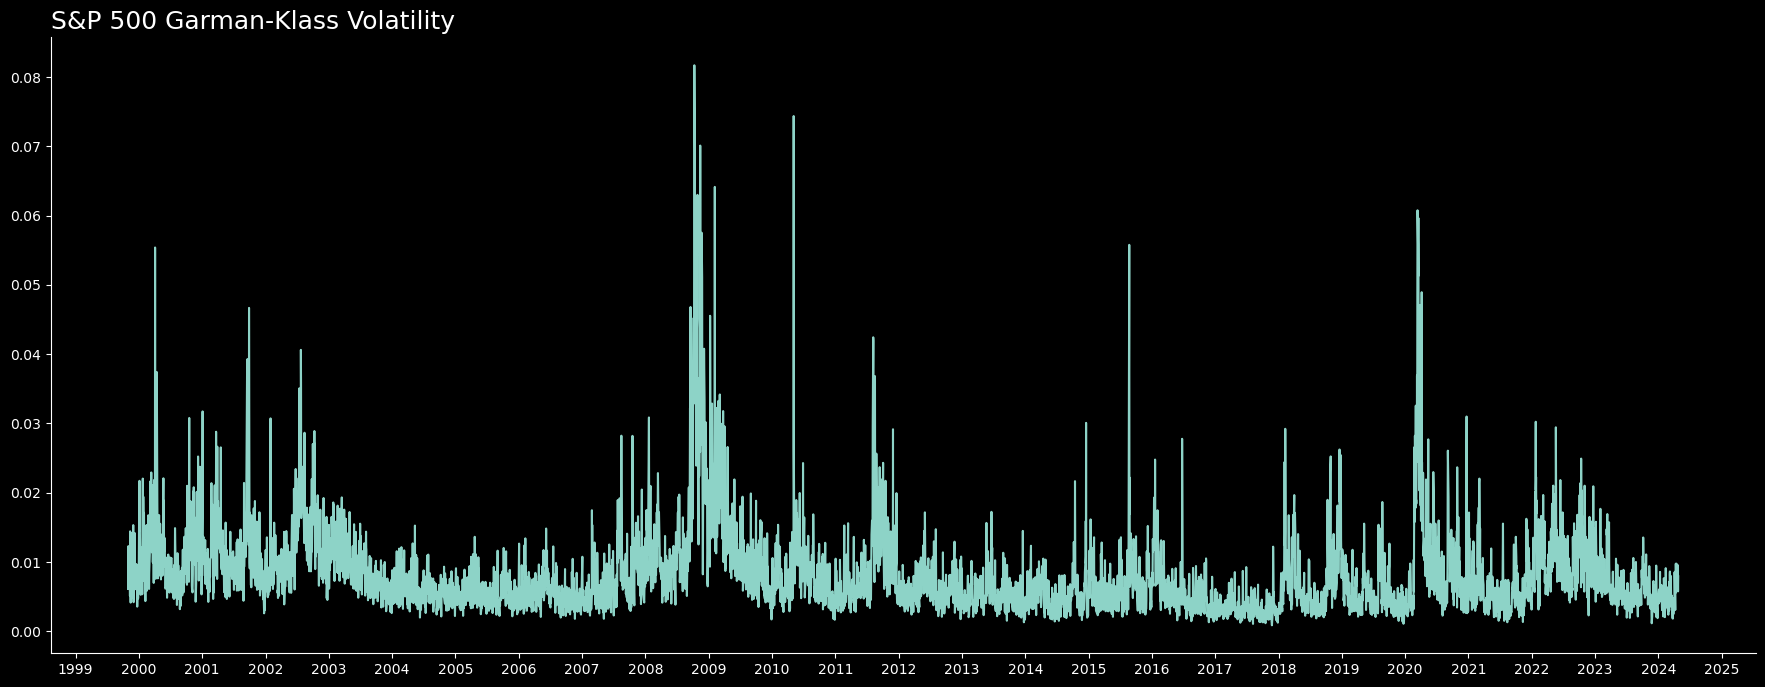

In [11]:
# Plot garman_klass volatility
plt.style.use('dark_background')
plt.figure(figsize=(22, 8))
plt.plot(df_spy.index, df_spy['gk_volatility'])

# Set the x-axis ticks to years
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set title
plt.title('S&P 500 Garman-Klass Volatility',
          loc='left',
          fontsize=18
          )


sns.despine()
plt.show();

Key Events Behind Volatility Peaks

1. **2008-2009: Great Recession**  
   The global financial crisis caused extreme market instability due to the collapse of major financial institutions, a housing market crash, and high uncertainty.

2. **2010: Flash Crash**  
   On May 6, there was a sudden and severe drop in U.S. stock markets, followed by a rapid rebound. This event was attributed to high-frequency trading, algorithmic anomalies, and market imbalances.

3. **2011: Occupy Wall Street Movement**  
   From September 17 to November 15, a movement protesting economic inequality and corporate influence took place, highlighting public discontent with the financial system. This led to further uncertainty in financial markets.

4. **2015: Chinese Stock Market Turmoil**  
   In 2015, the Chinese stock market experienced significant volatility, with sharp swings and a steep decline. The turmoil in China, one of the world's largest economies, caused global market instability.

5. **2020: COVID-19 Pandemic**  
   The COVID-19 pandemic caused significant market disruption starting in early 2020. Lockdowns, supply chain interruptions, and widespread uncertainty led to unprecedented volatility. The rollout of vaccines and evolving public health responses continued to impact markets throughout 2020 and into 2021.

## The Relative Strength Index (RSI)

The Relative Strength Index (RSI) is a momentum oscillator used to measure the speed and change of price movements. It ranges from 0 to 100 and is commonly used in technical analysis to identify overbought and oversold conditions in a market or stock. An RSI above 70 often indicates an overbought condition, suggesting a potential reversal or correction, while an RSI below 30 indicates an oversold condition, possibly signaling a rebound.

RSI is calculated by comparing the average gains and losses over a specific period, typically 14 days. The formula for RSI is:

$$
\text{RSI} = 100 - \frac{100}{1 + \text{RS}}
$$

where:

- **Relative Strength**: $ \text{RS} = \frac{\text{Average Gain}}{\text{Average Loss}}$
- **Average Gain**: The average of the gains over the period.
- **Average Loss**: The average of the losses over the same period.

We are using pandas_ta (Pandas Technical Analysis) library to calculate the RSI.


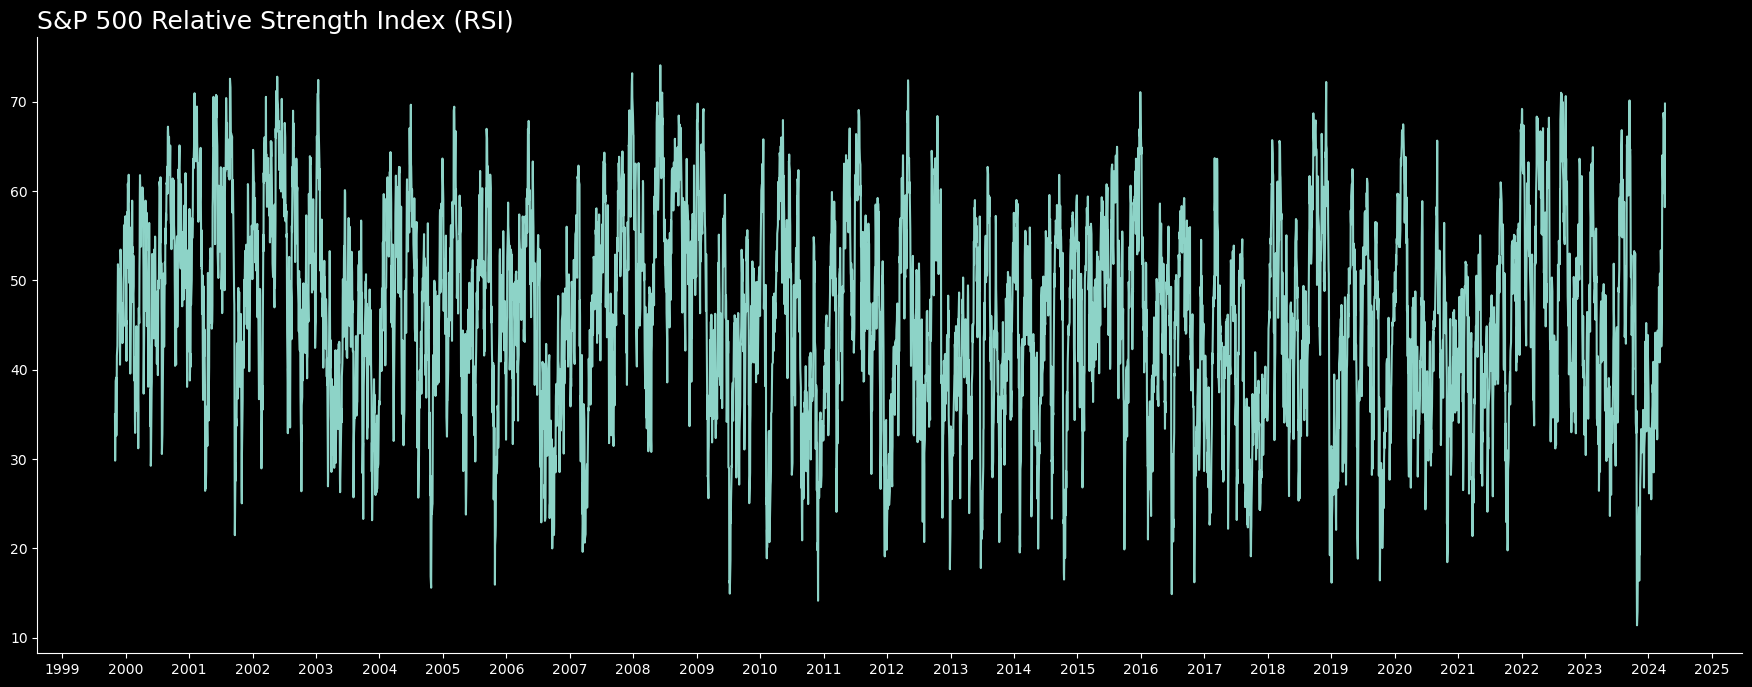

In [30]:
# Calculate RSI
df_spy['rsi'] = ta.rsi(close=df_spy['close'], length=14)

# Plot garman_klass volatility
plt.style.use('dark_background')
plt.figure(figsize=(22, 8))
plt.plot(df_spy.index, df_spy['rsi'])

# Set the x-axis ticks to years
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set title
plt.title('S&P 500 Relative Strength Index (RSI)',
          loc='left',
          fontsize=18
          )


sns.despine()
plt.show();

## Bollinger Bands